In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from pathlib import Path
from functools import partial
from copy import copy
from typing import List
from time import perf_counter
from collections import deque

In [3]:
from environments.easy21 import (
    EasyAction, 
    EasyState, 
    EasyEnvironment,
    DealerAgent, 
    MCAgent, 
    EpsilonGreedyPolicy
)

from environments.base import Transition
from environments.utils import StateActionPair

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

In [5]:
def plot_value_function(df_V, ax = None):

    if not ax:
        fig = plt.figure(figsize=(15, 8))
        ax = fig.add_subplot(111, projection='3d')
    
    # Prepare X and Y dimensions
    x_linspace = df_V["Dealer showing"]
    y_linspace = np.array(df_V.columns[1:], dtype=int)
    x, y = np.meshgrid(x_linspace, y_linspace)
    
    # Plot the surface.
    surf = ax.plot_surface(x, y, df_V[:, 1:].to_numpy().transpose(), 
                           cmap=cm.coolwarm,
                           rstride=1, cstride=1,
                           linewidth=0, antialiased=False)

    ax.set_xlabel("Dealer showing")
    ax.set_ylabel("Player sum")

    plt.show()
    
    return surf


def animate(checkpoints, name):
    
    # Adjusted from https://github.com/hereismari/easy21/blob/master/easy21.ipynb
    
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    def plot_frame(idx):
        ax.clear()
        surf = plot_value_function(
            df_V=checkpoints[idx],
            ax=ax
        )
        fig.canvas.draw()
        return surf
    
    ani = animation.FuncAnimation(fig, plot_frame, len(checkpoints), repeat=False)
    
    # Prepare path 
    p = Path().cwd().parent / "animations"
    p.mkdir(exist_ok=True)
    p = p / f"{name}.gif"
    
    # Save animation
    ani.save(p, writer='imagemagick', fps=3)
    
    plt.show()


def print_progress(i, n, t_start, rewards):
    mean_reward = np.array(rewards).mean() if rewards else 0
    time_elapsed =  perf_counter() - t_start

    print(
        f"Episode: {i:>10}/{n} "
        + f"--- {i/n*100:>5.1f} "
        + f"--- mean reward: {mean_reward:>5.2f} "
        + f"--- elapsed: {time_elapsed:>4.1f} seconds"
    )

## Monte-carlo control

In [6]:
n_episodes = 100000
n_checkpoints = 50

episodes_per_checkpoint = round(n_episodes / n_checkpoints)
rewards = deque(maxlen=episodes_per_checkpoint)

checkpoints = []

env = EasyEnvironment()

agent = MCAgent(
    policy=EpsilonGreedyPolicy(N_zero=100)
)

In [7]:
t_start = perf_counter()

for i in range(n_episodes):
    
    # Checkpoint: print progress and store value function
    if i % episodes_per_checkpoint == 0:
        
        print_progress(i, n_episodes, t_start, rewards)
        t_start = perf_counter()
        
        if i > 1:
            checkpoints.append(agent.get_V())
    
    # Reset environment and episode transitions
    env.reset()
    episode: List[Transition] = []
    
    s = env.get_state()
    
    while not s.terminal:

        # Take step, first agent using current state, then environment using action
        a = agent.step(s)
        next_s, R = env.step(a)
        
        # Store rewards and transitions
        rewards.append(R)
        episode.append(Transition(s, a, next_s, R))
        
        # Set state to next state
        s = copy(next_s)
    
    agent.optimize(episode)

Episode:          0/100000 ---   0.0 --- mean reward:  0.00 --- elapsed:  0.0 seconds
Episode:       2000/100000 ---   2.0 --- mean reward: -0.07 --- elapsed:  0.6 seconds
Episode:       4000/100000 ---   4.0 --- mean reward: -0.07 --- elapsed:  0.5 seconds
Episode:       6000/100000 ---   6.0 --- mean reward: -0.01 --- elapsed:  0.5 seconds
Episode:       8000/100000 ---   8.0 --- mean reward: -0.02 --- elapsed:  0.5 seconds
Episode:      10000/100000 ---  10.0 --- mean reward: -0.02 --- elapsed:  0.5 seconds
Episode:      12000/100000 ---  12.0 --- mean reward: -0.01 --- elapsed:  0.5 seconds
Episode:      14000/100000 ---  14.0 --- mean reward:  0.02 --- elapsed:  0.5 seconds
Episode:      16000/100000 ---  16.0 --- mean reward: -0.01 --- elapsed:  0.5 seconds
Episode:      18000/100000 ---  18.0 --- mean reward: -0.02 --- elapsed:  0.5 seconds
Episode:      20000/100000 ---  20.0 --- mean reward:  0.05 --- elapsed:  0.5 seconds
Episode:      22000/100000 ---  22.0 --- mean reward: 

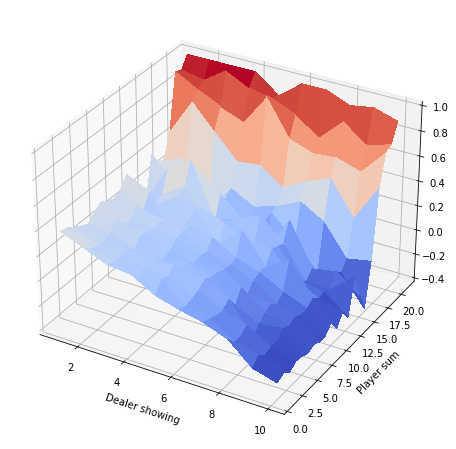

In [8]:
df_V = agent.get_V()

plot_value_function(df_V)

In [10]:
# animate(checkpoints, name="Easy21_MC_control")

![Value function surface plot](../animations/Easy21_MC_control.gif)